In [1]:
import unicodecsv

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
    
enrollments = read_csv('enrollments.csv')
daily_engagement = read_csv('daily-engagement.csv')
project_submissions = read_csv('project-submissions.csv')

 ## 处理数据
 修正数据类型

In [2]:
from datetime import datetime as dt

def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)
    
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])

In [3]:
for engagement in daily_engagement:
    engagement['utc_date'] = parse_date(engagement['utc_date'])
    engagement['total_minutes_visited'] = float(engagement['total_minutes_visited'])
    engagement['lessons_completed'] = int(float(engagement['lessons_completed']))
    engagement['num_courses_visited'] = int(float(engagement['num_courses_visited']))
    engagement['projects_completed'] = int(float(engagement['projects_completed']))

In [4]:
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

修正数据字段名称

In [5]:
for record in daily_engagement:
    record['account_key'] = record['acct']
    del record['acct']

 ## 调查数据
 统计Enrollments数据量大小及学生个数

In [6]:
def get_unique(data, key):
    
    unique_set = set()
    
    for item in data:
        unique_set.add(item[key])
    
    return unique_set

def get_unique_student(data):
    return get_unique(data, 'account_key')


In [7]:
print len(enrollments)
unique_enrollment_student = get_unique_student(enrollments)
print len(unique_enrollment_student)

1640
1302


统计Daily-Engagement数据量大小及学生个数

In [8]:
print len(daily_engagement)
unique_engagement_student = get_unique_student(daily_engagement)
print len(unique_engagement_student)

136240
1237


统计project_submissions统计量大小及学生个数

In [9]:
print len(project_submissions)
unique_project_submission_student =  get_unique_student(project_submissions)
print len(unique_project_submission_student)

3642
743


In [10]:
daily_engagement[0]['account_key']

u'0'

缺失的参与记录

In [11]:
for enrollment in enrollments:
    student = enrollment['account_key']
    if student not in unique_engagement_student:
        print enrollment
        break

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


In [12]:
num_problem_students = 0
for enrollment in enrollments:
    student = enrollment['account_key']
    if (student not in unique_engagement_student and
        enrollment['days_to_cancel'] != 0):
            print enrollment
            num_problem_students += 1
            
num_problem_students

{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 1, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), u'days_to_cancel': 59}
{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 3, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 6, 17, 0, 0), u'days_to_cancel': 99}
{u'status': u'current', u'is_udacity': True, u'is_canceled': False, u'join_date': datetime.datetime(2015, 2, 25, 0, 0), u'account_key': u'1101', u'cancel_date': None, u'days_to_cancel': None}


3

移除测试账号

In [13]:
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [14]:
def remove_udacity_accounts(data):
    non_undacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_undacity_data.append(data_point)
    return non_undacity_data

In [15]:
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


In [16]:
paid_students = {}
for enrollment in non_udacity_enrollments:
    if(not enrollment['is_canceled'] or
      enrollment['days_to_cancel'] > 7):
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        if(account_key not in paid_students or
          enrollment_date > paid_students[account_key]):
            paid_students[account_key] = enrollment_date

print len(paid_students)

995


In [17]:
#返回是在预定后的一周内加入
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days >= 0 and time_delta.days < 7

In [18]:
def remove_free_trial_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    
    return new_data

In [19]:
paid_enrollments = remove_free_trial_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trial_cancels(non_udacity_engagement)
paid_submissions = remove_free_trial_cancels(non_udacity_submissions)

print len(paid_enrollments)
print len(paid_engagement)
print len(paid_submissions)

1293
134549
3618


In [20]:
paid_engagement_in_first_week = []
for engagement_record in paid_engagement:
    account_key = engagement_record['account_key']
    join_date = paid_students[account_key]
    engagement_record_date = engagement_record['utc_date']
    
    if within_one_week(join_date, engagement_record_date):
        paid_engagement_in_first_week.append(engagement_record)
        
print len(paid_engagement_in_first_week)

6919


In [21]:
from collections import defaultdict

engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [22]:
total_minutes_by_account = {}

for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [23]:
total_minutes = total_minutes_by_account.values()

import numpy as np

print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


In [24]:
student_with_max_minutes = None
max_minutes = 0

for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > max_minutes:
        max_minutes = total_minutes
        student_with_max_minutes = student
        
max_minutes

3564.7332644989997

In [25]:
for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] == student_with_max_minutes:
        print engagement_record

{u'lessons_completed': 4, u'num_courses_visited': 4, u'total_minutes_visited': 850.519339666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 6, u'total_minutes_visited': 872.633923334, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)}
{u'lessons_completed': 6, u'num_courses_visited': 2, u'total_minutes_visited': 777.018903666, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)}
{u'lessons_completed': 2, u'num_courses_visited': 1, u'total_minutes_visited': 294.568774, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)}
{u'lessons_completed': 1, u'num_courses_visited': 3, u'total_minutes_visited': 471.2139785, u'projects_completed': 0, 'account_key': u'163', u'utc_date': datetime.datetime(2015, 7, 13, 0, 0)}
{u'lessons_completed': 1, u'num_cour

In [26]:
from collections import defaultdict

def group_data(data, key_name):
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data

engagement_by_account = group_data(paid_engagement_in_first_week, 'account_key')

In [27]:
def sum_grouped_items(grouped_data, field_name):
    summed_data = {}
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data

total_minutes_by_account = sum_grouped_items(engagement_by_account, 'total_minutes_visited')

In [28]:
import numpy as np

def describe_data(data):
    print 'mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minimum:', np.min(data)
    print 'Maxmum', np.max(data)
    
describe_data(total_minutes_by_account.values())

mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maxmum 3564.7332645


`第一周完成的课程

In [29]:
lessons_completed_by_account = sum_grouped_items(engagement_by_account, 'lessons_completed')
describe_data(lessons_completed_by_account.values())

mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maxmum 36


第一周访问数

In [30]:
for engagement_record in paid_engagement:
    if engagement_record['num_courses_visited'] > 0:
        engagement_record['has_visited'] = 1
    else:
        engagement_record['has_visited'] = 0

In [31]:
days_visited_by_account = sum_grouped_items(engagement_by_account, 'has_visited')
describe_data(days_visited_by_account.values())

mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maxmum 7


划分及格学员

In [32]:
subway_project_lesson_keys = ['746169184', '3176718735']

pass_subway_project = set()

for submission in paid_submissions:
    project = submission['lesson_key']
    rating = submission['assigned_rating']
    
    if((project in subway_project_lesson_keys) and
      (rating == 'PASSED' or rating == 'DISTINCTION')):
        pass_subway_project.add(submission['account_key'])
        
len(pass_subway_project)

647

In [33]:
passing_engagement = []
non_passing_engagement = []

for engagement_record in paid_engagement_in_first_week:
    if engagement_record['account_key'] in pass_subway_project:
        passing_engagement.append(engagement_record)
    else:
        non_passing_engagement.append(engagement_record)
        
print len(passing_engagement)
print len(non_passing_engagement)

4527
2392


比较两组学员

non-passing students:
Mean: 143.326474267
Standard deviation: 269.538619011
Minmum: 0.0
Maxmum: 1768.52274933


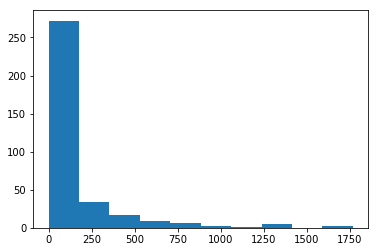

In [59]:
passing_engagement_by_account = group_data(passing_engagement, 'account_key')
non_passing_engagement_by_account = group_data(non_passing_engagement, 'account_key')

print 'non-passing students:'
non_passing_minutes = sum_grouped_items(
    non_passing_engagement_by_account,
    'total_minutes_visited')
describe_data(non_passing_minutes.values())

passing students:
Mean: 394.586046484
Standard deviation: 448.499519327
Minmum: 0.0
Maxmum: 3564.7332645


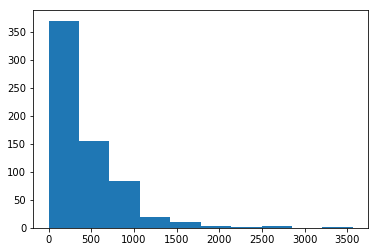

In [58]:
print 'passing students:'
passing_minutes = sum_grouped_items(
    passing_engagement_by_account,
    'total_minutes_visited')
describe_data(passing_minutes.values())

non-passing student:
Mean: 0.862068965517
Standard deviation: 2.54915994183
Minmum: 0
Maxmum: 27


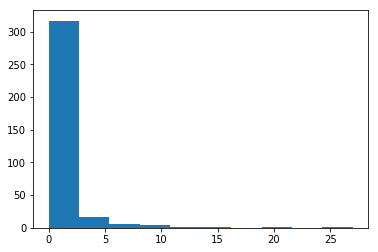

In [57]:
print 'non-passing student:'
non_passing_lessons = sum_grouped_items(
    non_passing_engagement_by_account,
    'lessons_completed')
describe_data(non_passing_lessons.values())

passing students:
Mean: 2.05255023184
Standard deviation: 3.14222705558
Minmum: 0
Maxmum: 36


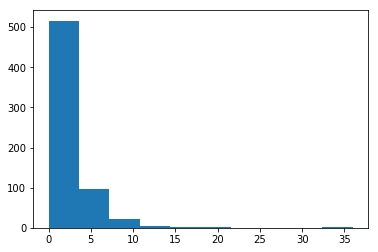

In [56]:
print 'passing students:'
passing_lessons = sum_grouped_items(
    passing_engagement_by_account,
    'lessons_completed')
describe_data(passing_lessons.values())

non-passing students:


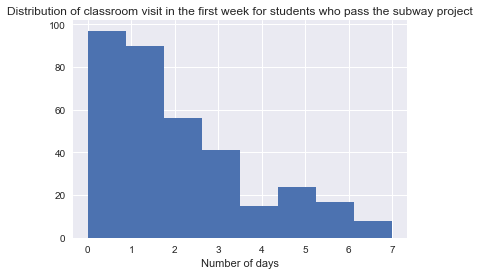

In [82]:
print 'non-passing students:'
sns.set(color_codes=True)
non_passing_visits = sum_grouped_items(
    non_passing_engagement_by_account,
    'has_visited')
#describe_data(non_passing_visits.values())
plt.hist(non_passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visit in the first week '+
        'for students who pass the subway project')

passing students:


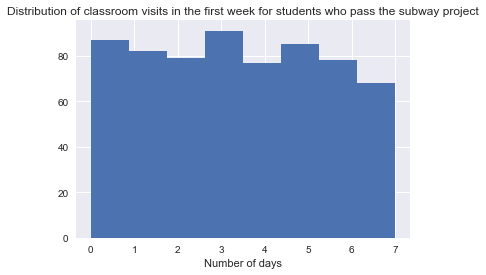

In [81]:
print 'passing students:'
sns.set(color_codes=True)
passing_visits = sum_grouped_items(
    passing_engagement_by_account,
    'has_visited')
plt.hist(passing_visits.values(), bins=8)
plt.xlabel('Number of days')
plt.title('Distribution of classroom visits in the first week ' +
         'for students who pass the subway project')

(array([ 3.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

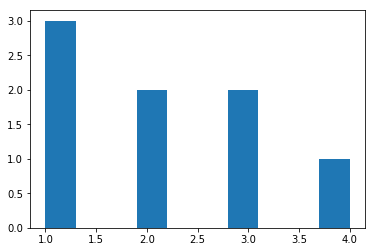

In [69]:
data = [1, 2, 1, 3, 3, 1, 4, 2]

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(data)

通过和未通过地铁项目考核的学员直方图

In [66]:
%pylab inline
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

def describe_data(data):
    print 'Mean:', np.mean(data)
    print 'Standard deviation:', np.std(data)
    print 'Minmum:', np.min(data)
    print 'Maxmum:', np.max(data)
    plt.hist(data)

Populating the interactive namespace from numpy and matplotlib
